In [4]:
import pandas as pd

# Use a raw string for the file path
df = pd.read_csv(r"Online Retail Data Set.csv", encoding='ISO-8859-1')

# View basic info
print(df.head())
print(df.info())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   

In [16]:
# Data Cleaning and Preparation

# Handle missing values
df.dropna(subset=['Description'], inplace=True)
# Convert CustomerID to string type to allow filling with 'Unknown'
df['CustomerID']=df['CustomerID'].astype('object')           # Ensure type is object
df['CustomerID']=df['CustomerID'].fillna('Unknown')          # Fill missing values

# Remove Duplicates
df.drop_duplicates(inplace=True)

# Inconsistent data
df['Description']=df['Description'].str.strip().str.lower()  # Standardize Description
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]              # Remove rows with invalid values

# Create derived columns
df['Revenue']=df['Quantity'] * df['UnitPrice']               # Create Revenue column
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'], dayfirst=True,errors='coerce') # convert InvoiceDate to datetime and extract YearMonth
df['YearMonth']=df['InvoiceDate'].dt.to_period('M')

# Retention rates
df['FirstPurchase']=df.groupby('CustomerID')['InvoiceDate'].transform('min') # First purchase date per customer
df['IsReturning']=df['InvoiceDate']>df['FirstPurchase'] # Flag returning customers

print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   white hanging heart t-light holder         6   
1         536365     71053                  white metal lantern         6   
2         536365    84406B       cream cupid hearts coat hanger         8   
3         536365    84029G  knitted union flag hot water bottle         6   
4         536365    84029E       red woolly hottie white heart.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          pack of 20 spaceboy napkins        12   
541905    581587     22899          children's apron dolly girl         6   
541906    581587     23254         childrens cutlery dolly girl         4   
541907    581587     23255      childrens cutlery circus parade         4   
541908    581587     22138         baking set 9 piece retrospot         3   

               InvoiceDate  UnitPrice CustomerID         Country  Revenue  

In [17]:
# Exploratory Data Analysis(EDA)

# Top-Performing Products
top_products=df.groupby('Description')['Revenue'].sum().sort_values(ascending=False)  # Top products by revenue
print(top_products)

Description
dotcom postage                        206248.770
regency cakestand 3 tier              174156.540
paper craft , little birdie           168469.600
white hanging heart t-light holder    106236.720
party bunting                          99445.230
                                         ...    
pink crystal guitar phone charm            0.850
vintage blue tinsel reel                   0.840
set 12 colouring pencils doiley            0.650
hen house w chick in nest                  0.420
pads to match all cushions                 0.003
Name: Revenue, Length: 4015, dtype: float64


In [38]:
# Top Regions
top_regions=df.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
print(top_regions.head(5))

Country
United Kingdom    9001744.094
Netherlands        285446.340
EIRE               283140.520
Germany            228678.400
France             209625.370
Name: Revenue, dtype: float64


In [45]:
# Top SalesChannel
if 'SalesChannel' in df.columns:
    top_channels = df.groupby('SalesChannel')['Revenue'].sum().sort_values(ascending=False)
    print("Top-performing sales channels:")
    print(top_channels)
else:
    print("SalesChannel column not found.")

SalesChannel column not found.


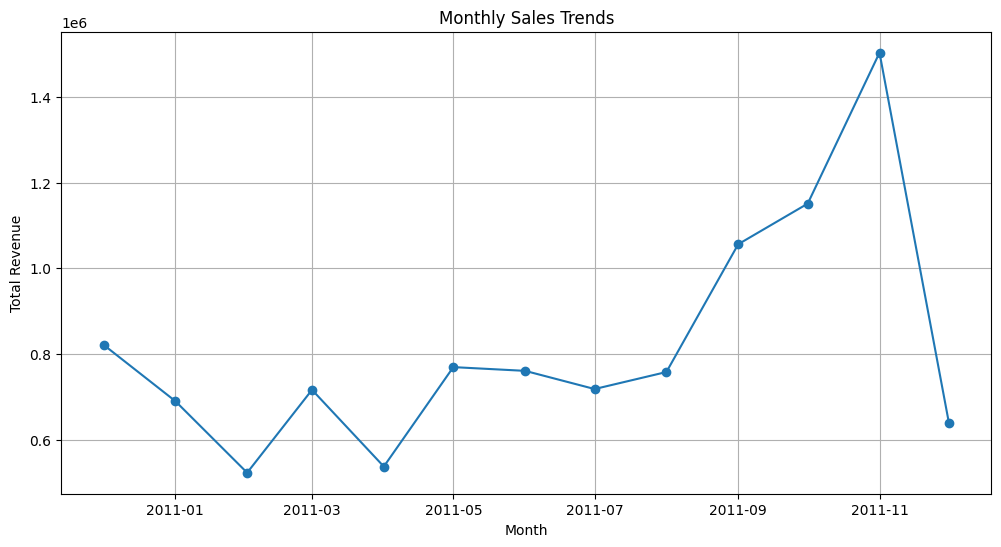

In [48]:
# Seasonal Trends
# Aggregate revenue by date
daily_sales = df.groupby('InvoiceDate')['Revenue'].sum().reset_index()

# Convert 'InvoiceDate' to datetime if not already
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

# Group by month to detect seasonal trends
monthly_sales = (daily_sales.groupby(daily_sales['InvoiceDate'].dt.to_period('M'))['Revenue'].sum().reset_index())

# Convert the period back to a datetime for plotting
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()

# Plot monthly sales trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['Revenue'], marker='o')
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()


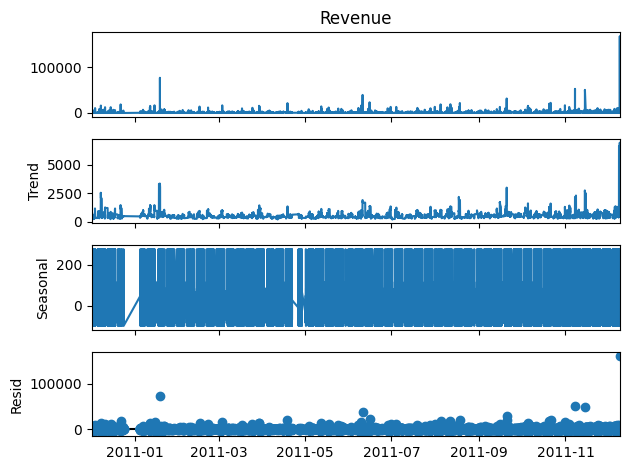

In [47]:
# Anomalies in Sales Data
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
daily_sales = daily_sales.set_index('InvoiceDate')
decompose_result = seasonal_decompose(daily_sales['Revenue'], model='additive', period=30)

# Plot decomposition
decompose_result.plot()
plt.show()


In [50]:
# Customer Segmentation
# Ensure 'Revenue' is numeric
df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')

# Ensure 'CustomerID' is numeric
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce')

# Remove rows with NaN values in 'Revenue' or 'CustomerID'
df = df.dropna(subset=['Revenue', 'CustomerID'])

# Group data by CustomerID to calculate revenue and frequency
customer_revenue = df.groupby('CustomerID')['Revenue'].sum()
customer_frequency = df['CustomerID'].value_counts()

# Combine into a summary DataFrame
customer_summary = pd.DataFrame({
    'Revenue': customer_revenue,
    'Frequency': customer_frequency
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={'index': 'CustomerID'}, inplace=True)

# Display top rows of customer summary
print(customer_summary.head())



   CustomerID   Revenue  Frequency
0     12346.0  77183.60          1
1     12347.0   4310.00        182
2     12348.0   1797.24         31
3     12349.0   1757.55         73
4     12350.0    334.40         17


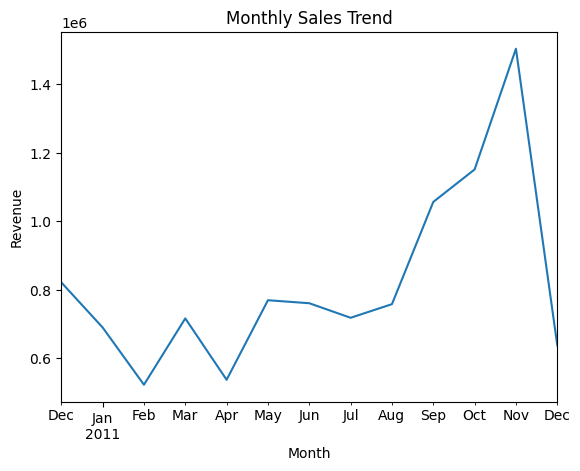

In [21]:
# Visualization

# Sales Trend Analysis
import matplotlib.pyplot as plt

# Plot Sales trend
monthly_revenue.plot(kind='line', title='Monthly Sales Trend', xlabel='Month', ylabel='Revenue')
plt.show()

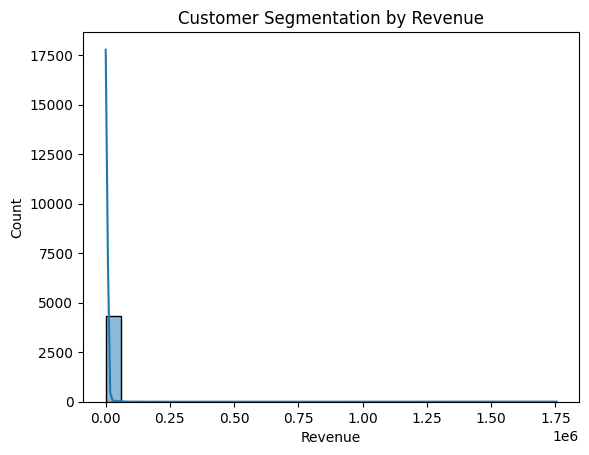

In [22]:
# Customer Segmentation

import seaborn as sns

# plot customer segments
sns.histplot(df.groupby('CustomerID')['Revenue'].sum(), bins=30, kde=True)
plt.title('Customer Segmentation by Revenue')
plt.show()

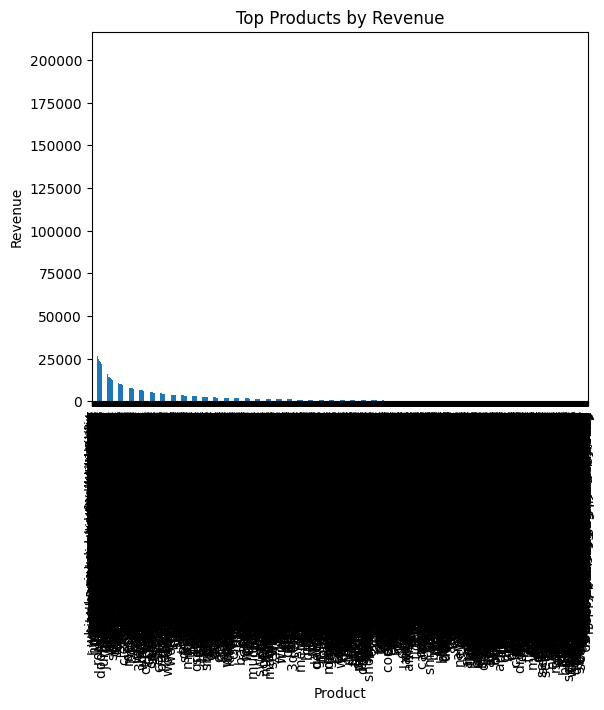

In [23]:
# Top Products

# Plot top products
top_products.plot(kind='bar', title='Top Products by Revenue', xlabel='Product', ylabel='Revenue')
plt.show()

In [54]:
# Insights and Recommendations

## 1. How to Increase Sales During Low-Performing Months
- **Insight**: Identify low-sales months and analyze contributing factors like reduced customer activity.
- **Recommendation**:
  - Implement promotional campaigns (e.g., discounts or bundles) during low-performing months.
  - Increase marketing efforts targeting specific regions or customer segments.

## 2. Retaining High-Value Customers
- **Insight**: High-value customers contribute a significant to total revenue.
- **Recommendation**:
  - Introduce loyalty programs with tiered rewards.
  - Use personalized marketing based on customer preferences and purchase history.

## 3. Product Recommendations Based on Customer Behavior
- **Insight**: Frequently purchased or paired products can reveal customer preferences.
- **Recommendation**:
  - Recommend complementary products through cross-selling strategies.
  - Suggest premium versions or add-ons through upselling at checkout.


In [55]:
# Forecasting

# Prepare Data for Forecasting
sales_forecasting=df.groupby('YearMonth')['Revenue'].sum().reset_index()
sales_forecasting['YearMonth']=sales_forecasting['YearMonth'].dt.to_timestamp()
print(sales_forecasting)

    YearMonth      Revenue
0  2010-12-01   570422.730
1  2011-01-01   568101.310
2  2011-02-01   446084.920
3  2011-03-01   594081.760
4  2011-04-01   468374.331
5  2011-05-01   677355.150
6  2011-06-01   660046.050
7  2011-07-01   598962.901
8  2011-08-01   644051.040
9  2011-09-01   950690.202
10 2011-10-01  1035642.450
11 2011-11-01  1156205.610
12 2011-12-01   517190.440


In [33]:
# Linear Regression

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare features
sales_forecasting['MonthIndex']=np.arange(len(sales_forecasting))

# Define X and y
X=sales_forecasting[['MonthIndex']]
y=sales_forecasting['Revenue']

# Ensure 'Revenue' is numeric
y=pd.to_numeric(y, errors='coerce')

# Train model
model=LinearRegression()
model.fit(X, y)

# Predict next month
next_month=np.array([[len(sales_forecasting)]])
prediction=model.predict(next_month)
print(f"Predicted revenue for next month: {prediction[0]:.2f}")

# Evaluate model
y_pred=model.predict(X)
mse=mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Predicted revenue for next month: 1083791.57
Mean Squared Error: 47845149707.35


Forecasted Value: 144456.77796049142


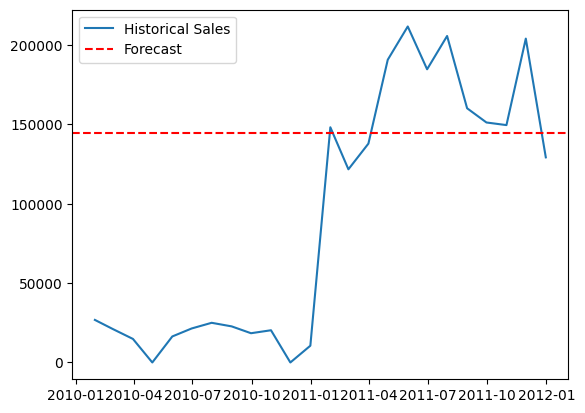

In [66]:
# ARIMA 
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('Online Retail Data Set.csv', encoding='ISO-8859-1')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
data.set_index('InvoiceDate',inplace=True)

# Aggregrate sales data by month
monthly_sales = data['Quantity'].resample('ME').sum()

# Explicitly set frequency
monthly_sales=monthly_sales.asfreq('ME')

# Fit ARIMA model
model = ARIMA(monthly_sales, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=1)
print("Forecasted Value:", forecast.iloc[0])

# Plot
plt.plot(monthly_sales, label='Historical Sales')
plt.axhline(forecast.iloc[0], color='red', linestyle='--', label='Forecast')
plt.legend()
plt.show()


In [35]:
# Deliverables

print("Predicted Revenue:")
print(f"Predicted revenue for next month: ${prediction[0]:.2f}")
print()
print("Mean Squared Error (MSE):")
print(f"Mean Squared Error: {mse:.2f}")

Predicted Revenue:
Predicted revenue for next month: $1083791.57

Mean Squared Error (MSE):
Mean Squared Error: 47845149707.35
